In [1]:
!pip install efficientnet_pytorch

  Preparing metadata (setup.py) ... - done
  Created wheel for efficientnet_pytorch: filename=efficientnet_pytorch-0.7.1-py3-none-any.whl size=16446 sha256=208d9c355c7f354d1e0bf9b082a3712b4ac7aae20fd6a47c9c12c7bcc2cd73cc
  Stored in directory: /root/.cache/pip/wheels/0e/cc/b2/49e74588263573ff778da58cc99b9c6349b496636a7e165be6
Successfully built efficientnet_pytorch


In [2]:
import numpy as np
import pandas as pd
import warnings
import random
import h5py
import torch
import matplotlib.pyplot as plt

from matplotlib import pyplot
from IPython.display import display
from torch.utils.data import DataLoader, Dataset
from torch.utils import data
from PIL import Image, ImageDraw


warnings.filterwarnings('ignore')

%matplotlib inline

SEED = 21
random.seed(SEED)
np.random.seed(SEED)

In [3]:
from torchvision import transforms

device = ("cuda" if torch.cuda.is_available() else "cpu")
learning_rate = 0.01
image_size = 96

train_transforms = transforms.Compose([
    transforms.RandomChoice([
        transforms.ColorJitter(brightness=0.5),
        transforms.ColorJitter(contrast=0.5), 
        transforms.ColorJitter(saturation=0.5),
        transforms.ColorJitter(hue=0.5),
        transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1, hue=0.1), 
        transforms.ColorJitter(brightness=0.3, contrast=0.3, saturation=0.3, hue=0.3), 
        transforms.ColorJitter(brightness=0.5, contrast=0.5, saturation=0.5, hue=0.5), 
    ]),
    transforms.RandomChoice([
        transforms.RandomRotation((0, 0)),
        transforms.RandomHorizontalFlip(p=1),
        transforms.RandomVerticalFlip(p=1),
        transforms.RandomRotation((90,90)),
        transforms.RandomRotation((180,180)),
        transforms.RandomRotation((270,270)),
        transforms.Compose([
            transforms.RandomHorizontalFlip(p=1),
            transforms.RandomRotation((90,90)),
        ]),
        transforms.Compose([
            transforms.RandomHorizontalFlip(p=1),
            transforms.RandomRotation((270,270)),
        ]) 
    ]),
    transforms.Resize(image_size), 
    transforms.CenterCrop(image_size),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )
])

test_transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

print(device)

cuda


In [4]:
if device == "cuda":
    torch.backends.cudnn.benchmark = True
    print("cuDNN auto-tuner is enabled")

cuDNN auto-tuner is enabled


In [5]:
class PCamDataset(Dataset):
    def __init__(self, path, transforms):
        self.path = path
        self.X = h5py.File(self.path +'_x.h5', 'r')['x']
        self.y = h5py.File(self.path +'_y.h5', 'r')['y']
        self.transforms = transforms

    def __getitem__(self, index):
        return (self.transforms(Image.fromarray(self.X[index,:,:,:])), self.y[index])

    def __len__(self):
        assert len(self.X) == len(self.y)
        return len(self.X)

In [6]:
data_dir = "../input/patchcamelyon/"

train = PCamDataset(data_dir + "camelyonpatch_level_2_split_train", train_transforms)
valid = PCamDataset(data_dir + "camelyonpatch_level_2_split_valid", test_transforms)
test = PCamDataset(data_dir + "camelyonpatch_level_2_split_test", test_transforms)

print(len(train), len(valid), len(test))

262144 32768 32768


In [7]:
train_loader = DataLoader(train, batch_size=8, shuffle=True, num_workers=0)
valid_loader = DataLoader(valid, batch_size=8, shuffle=False, num_workers=0)
test_loader = DataLoader(test, batch_size=8, shuffle=False, num_workers=0)

In [8]:
import torch.nn as nn
from efficientnet_pytorch import EfficientNet

efficientnet_b0 = EfficientNet.from_name('efficientnet-b0')
efficientnet_b0._fc = nn.Linear(1280,  1)

In [9]:
import torch.optim as optim

optimizer = optim.Adam(efficientnet_b0.parameters(), lr=learning_rate)
criterion = nn.BCEWithLogitsLoss()

In [10]:
efficientnet_b0

EfficientNet(
  (_conv_stem): Conv2dStaticSamePadding(
    3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False
    (static_padding): ZeroPad2d(padding=(0, 1, 0, 1), value=0.0)
  )
  (_bn0): BatchNorm2d(32, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
  (_blocks): ModuleList(
    (0): MBConvBlock(
      (_depthwise_conv): Conv2dStaticSamePadding(
        32, 32, kernel_size=(3, 3), stride=[1, 1], groups=32, bias=False
        (static_padding): ZeroPad2d(padding=(1, 1, 1, 1), value=0.0)
      )
      (_bn1): BatchNorm2d(32, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
      (_se_reduce): Conv2dStaticSamePadding(
        32, 8, kernel_size=(1, 1), stride=(1, 1)
        (static_padding): Identity()
      )
      (_se_expand): Conv2dStaticSamePadding(
        8, 32, kernel_size=(1, 1), stride=(1, 1)
        (static_padding): Identity()
      )
      (_project_conv): Conv2dStaticSamePadding(
        32, 16, kernel_size=

In [11]:
%%time

from sklearn.metrics import roc_auc_score

epochs = 6
train_loss_history = np.empty(0)
train_accuracy_history = np.empty(0)
valid_loss_history = np.empty(0)
valid_accuracy_history = np.empty(0)
best_roc_auc = 0.5

efficientnet_b0 = efficientnet_b0.to(device)

efficientnet_b0.train()
for epoch in range(epochs):
    preds_in_current_epoch = torch.empty(0, device=device)
    labels_in_current_epoch = torch.empty(0, device=device)
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        target = torch.reshape(target, (8, 1)).float()
        optimizer.zero_grad()
        out = efficientnet_b0(data)
        loss = criterion(out, target)
        loss.backward()
        optimizer.step()
        preds_in_current_epoch = torch.cat((preds_in_current_epoch, torch.sigmoid(out)))
        labels_in_current_epoch = torch.cat((labels_in_current_epoch, target))
    
    labels_in_current_epoch = torch.squeeze(labels_in_current_epoch)
    total = len(labels_in_current_epoch)
    preds_in_current_epoch = torch.squeeze(preds_in_current_epoch)
    correct = ((preds_in_current_epoch > 0.5).float() == labels_in_current_epoch).sum().item()
    loss = criterion(preds_in_current_epoch, labels_in_current_epoch)
    accuracy = round(correct / total, 4)
    
    train_accuracy_history = np.append(train_accuracy_history, accuracy)
    train_loss_history = np.append(train_loss_history, loss.cpu().detach().numpy())

    print(f"Train Epoch: {epoch + 1}, Loss: {loss}, Accuracy: {accuracy}")
    
    valid_labels = (torch.squeeze(torch.as_tensor(valid.y))).to(device)

    with torch.no_grad():
        predictions = torch.Tensor().float().to(device)

        for batch_idx, (data, target) in enumerate(valid_loader):
            data, target = data.to(device), target.to(device)
            target = torch.reshape(target, (8, 1)).float()
            out = efficientnet_b0(data)
            predictions = torch.cat((predictions, torch.sigmoid(out)))

        total = valid_labels.shape[0]
        predictions = torch.squeeze(predictions)
        correct = ((predictions > 0.5).float() == valid_labels).sum().item()
        loss = criterion(predictions, valid_labels.float())
        accuracy = round(correct / total, 4)
                                    
        valid_accuracy_history = np.append(valid_accuracy_history, accuracy)
        valid_loss_history = np.append(valid_loss_history, loss.cpu().detach().numpy())

        print(f"Valid Loss: {loss}, Valid Accuracy: {accuracy}")
        
        current_roc_auc = roc_auc_score(valid_labels.cpu().detach().numpy(), predictions.cpu().detach().numpy())
        print(f"ROC-AUC score = {current_roc_auc}")
        if current_roc_auc > best_roc_auc:
            torch.save(efficientnet_b0.state_dict(), "best_roc_auc_checkpoint.pth")
            print("Model saved successfully\n")
            best_roc_auc = current_roc_auc
        else:
            print()

efficientnet_b0.eval()
torch.save(efficientnet_b0.state_dict(), "checkpoint.pth")

Train Epoch: 1, Loss: 0.6580660939216614, Accuracy: 0.7335
Valid Loss: 0.6809329986572266, Valid Accuracy: 0.6107
ROC-AUC score = 0.6640486453136251
Model saved successfully

Train Epoch: 2, Loss: 0.63222336769104, Accuracy: 0.7891
Valid Loss: 0.646872878074646, Valid Accuracy: 0.7591
ROC-AUC score = 0.8247754893246482
Model saved successfully

Train Epoch: 3, Loss: 0.6199121475219727, Accuracy: 0.8098
Valid Loss: 0.6264729499816895, Valid Accuracy: 0.772
ROC-AUC score = 0.8545570197527462
Model saved successfully

Train Epoch: 4, Loss: 0.6127398014068604, Accuracy: 0.823
Valid Loss: 0.6305419206619263, Valid Accuracy: 0.8163
ROC-AUC score = 0.9059309245439545
Model saved successfully

Train Epoch: 5, Loss: 0.6066275835037231, Accuracy: 0.8343
Valid Loss: 0.6169100403785706, Valid Accuracy: 0.809
ROC-AUC score = 0.8950015916502405

Train Epoch: 6, Loss: 0.601293683052063, Accuracy: 0.8435
Valid Loss: 0.6113907098770142, Valid Accuracy: 0.8305
ROC-AUC score = 0.9080716197047921
Model sa

In [12]:
from sklearn.metrics import classification_report
from sklearn.metrics import roc_auc_score

classes = ['+', '-']
test_labels = (torch.squeeze(torch.Tensor(test.y))).to(device)

with torch.no_grad():
    predictions = torch.empty(0, device=device)
    
    for batch_idx, (data, target) in enumerate(test_loader):
        data, target = data.to(device), target.to(device)
        target = torch.reshape(target, (8, 1)).float()
        out = efficientnet_b0(data)
        loss = criterion(out, target)
        predictions = torch.cat((predictions, torch.sigmoid(out)))
                                
    total = test_labels.shape[0]
    predictions = torch.squeeze(predictions)
    correct = ((predictions > 0.5).float() == test_labels).sum().item()
    loss = criterion(predictions, test_labels)
    accuracy = round(correct / total, 5)
                                
    print(f"Test Loss: {loss}\nTest Accuracy: {accuracy}")
    
    predictions = predictions.cpu().detach().numpy()
    for i in range(len(predictions)):
        predictions[i] = 1.0 if predictions[i] > 0.5 else 0.0
    
    print(classification_report(test_labels.cpu().detach().numpy(), 
                                predictions, 
                                target_names=classes))
    print(f"ROC-AUC = {roc_auc_score(test_labels.cpu().detach().numpy(), predictions)}")

Test Loss: 0.5998784303665161
Test Accuracy: 0.86462
              precision    recall  f1-score   support

           +       0.87      0.86      0.86     16391
           -       0.86      0.87      0.87     16377

    accuracy                           0.86     32768
   macro avg       0.86      0.86      0.86     32768
weighted avg       0.86      0.86      0.86     32768

ROC-AUC = 0.8646256676564281


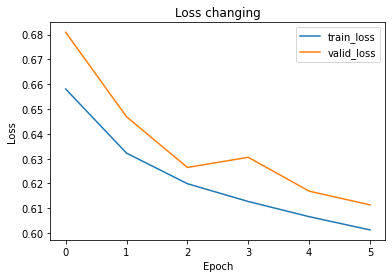

In [13]:
train_loss_idx = list(range(0, len(train_loss_history)))
valid_loss_idx = list(range(0, len(valid_loss_history)))

plt.plot(train_loss_idx, train_loss_history, label="train_loss")
plt.plot(valid_loss_idx, valid_loss_history, label="valid_loss")

plt.xlabel("Epoch")
plt.ylabel("Loss")

plt.title("Loss changing")

plt.legend()
plt.show()

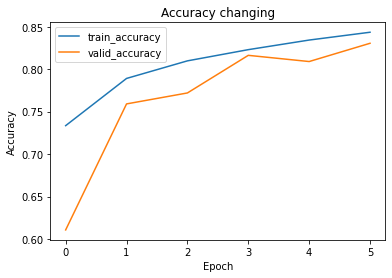

In [14]:
train_accuracy_idx = list(range(0, len(train_accuracy_history)))
valid_accuracy_idx = list(range(0, len(valid_accuracy_history)))

plt.plot(train_accuracy_idx, train_accuracy_history, label="train_accuracy")
plt.plot(valid_accuracy_idx, valid_accuracy_history, label="valid_accuracy")

plt.xlabel("Epoch")
plt.ylabel("Accuracy")

plt.title("Accuracy changing")

plt.legend()
plt.show()